In [1]:
import math
from typing import Any

import powerlaw as pl

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter

from torch.nn import Module
from scipy.stats import levy_stable,pareto
from torch.distributions.pareto import Pareto
from torch.nn import init
from torch.distributions.cauchy import Cauchy
from torch.distributions.laplace import Laplace
from torch.nn import init
seed=0
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2

#torch.cuda.manual_seed_all(seed)
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()



In [2]:
weight_tuning=1
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        #init.uniform_(self.weight, -bound,bound)
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
        init.uniform_(self.weight, -bound,bound)
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            init.uniform_(self.weight, -bound,bound)
        #fan = _calculate_correct_fan(tensor, mode)
        #gain = calculate_gain(nonlinearity, a)
        #std = gain / math.sqrt(fan)
        #bound = math.sqrt(3.0) * std  # Calculate uniform bounds from standard deviation
        #with torch.no_grad():
            #return tensor.uniform_(-bound, bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [3]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 14}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_output_layer = Linear(
            in_features=input_shape, out_features=encoder_output_shape
        ,bias=False)
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=input_shape
        ,bias=False)
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden
    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print(code)
       # print("hidden state maximum:"+str(torch.max(code)))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):

        code = self.encoder_output_layer(features)
        result = torch.relu(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        reconstructed = torch.relu(activation)
        
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [4]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.zeros(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            temp=result
            diff*=result**(1/no_of_image)
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
            if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
                diff=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=2**-52
            distance.append(diff)
            continue
        distance.append(diff.cpu().detach().numpy())

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]


In [5]:
def stats(tensor):
    # Calculate the mean
    mean = torch.mean(tensor)
    # Calculate the variance
    second = torch.mean(torch.pow(tensor,2))
    third = torch.mean(torch.pow(tensor,3))
    fourth=torch.mean(torch.pow(tensor,4))
    # Calculate the standard deviation
    var=torch.var(tensor)
    std = torch.sqrt(var)
    # Calculate the z-scores
    zscores = (tensor - mean) / std
    # Calculate the skewness
    skew = torch.mean(zscores ** 3)
    # Calculate the kurtosis
    kurt = torch.mean(zscores ** 4) - 3
    #Return the results as a tuple
    return mean, second, skew, kurt

In [6]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [7]:
pconv = lambda alpha, beta, mu, sigma: (alpha, beta, mu , sigma)
def test_fitstart(value):
    #draw = levy_stable.rvs(alpha, beta, size=points)
    
    # use scipy's quantile estimator to estimate the parameters and convert to S parameterization
    return pconv(*levy_stable._fitstart(value))

In [ ]:
import scipy.stats as st, levy
spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
epochs=1000
noise_strength=10**-3
perturbation_strength=10**-6
no_of_images=20
no_of_repetition=200
asymptotic_repetition=100
#diverge=[]
file=["relu-1-adam-1-layer","relu-2.5-adam-1-layer","tanh-1-adam-1-layer","tanh-2.5-adam-1-layer"]
#list of file to work on 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running")
path="/raid/home/sichen/phd-project/new runs/"
start=time.time()
#print("running")
#strength=0.1
#epochs=10
current_file=3
mu=1
dmu=1/epochs

init_compute=True
chao=[]
noise_print=False
repeats=1
average_chaos=[]
first_moment=[]
second_moment=[]
third_moment=[]
fourth_moment=[]
J0=[]
J1=[]
mu=[]
skewness=[]
for i in range(repeats):
    
    chao=[]
    asy_dist=[]
    print(i)
    for epoch in range(epochs+1):
        loss = 0
        #mu+=dmu
        #print(mu)
        model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
        if epoch==0:
            for batch_features, _ in train_loader:
            # reshape mini-batch data to [1000, 784] matrix
            # load it to the active device
                input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        #model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)           
        PATH=path+file[current_file]+"/epoch:"+str(epoch)+".pt"
        if epoch==0:
            print(PATH)
        model.load_state_dict(torch.load(PATH))
        save_image=input_image
        perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
        inits=0
        print(epoch)
        print("\n")
        for value in model.parameters():
            
            first,second,third,fourth=stats(value)
            first_moment.append(first.cpu().detach().numpy())
            second_moment.append(second.cpu().detach().numpy())
            third_moment.append(third.cpu().detach().numpy())
            fourth_moment.append(fourth.cpu().detach().numpy())
            print("here")
            result=pl.Fit(np.abs(value.cpu().detach().numpy()).flatten())
            print(result.alpha,result.xmin)
            #print(test_fitstart(value.cpu().detach().numpy().flatten()))
            #alpha,beta,jzero,jone=test_fitstart(value.cpu().detach().numpy().flatten())
            #if shape<=3:
             #   alpha,beta,jzero,jone=levy_stable.fit(value.cpu().detach().numpy().flatten())
              #  print(alpha,beta,jzero,jone)
                #print(draw)
            #else:
            first,second,third,fourth=stats(value)
            mu.append(result.alpha)
            skewness.append(third)
            J0.append(first)
            J1.append(second)
            inits+=1
        cutoff=[]
        for j in range(no_of_images):
            cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
        model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer,mu).to(device)
        model_clone.load_state_dict(copy.deepcopy(model.state_dict()))

        #spectral_radiuses=[]
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)

        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
          
        asy_dist.append(distance[-1])
        chao.append(chaos)
        #print(ave_jac)
        #mu+=dmu
    print("here\n") 
    np.savetxt("average_chaos"+str(i)+".txt",chao)
    average_chaos.append(chao)
    #print(average_chaos)
    asymptotic_dist.append(asy_dist)
    np.savetxt("asymptotic distance"+str(i)+".txt",asy_dist)


end=time.time()
print(end-start)

#print(chao)



running
0
/raid/home/sichen/phd-project/new runs/tanh-2.5-adam-1-layer/epoch:0.pt
0


here
Calculating best minimal value for power law fit
127.59869161950348 0.08785287003412032
here
Calculating best minimal value for power law fit
628.2093348992465 0.7873216414919012
1


here
Calculating best minimal value for power law fit
10.002768107981172 0.0724856351790653
here
Calculating best minimal value for power law fit
17.27575609673003 0.9365094135304811
2


here
Calculating best minimal value for power law fit
10.266102761509362 0.06991790745176096
here
Calculating best minimal value for power law fit
10.697273532868618 0.8411475292044941
3


here
Calculating best minimal value for power law fit
8.098780129920804 0.05835741859249295
here
Calculating best minimal value for power law fit
8.028829076962094 0.7412082261258023
4


here
Calculating best minimal value for power law fit
7.967486610713303 0.05972269522308678
here
Calculating best minimal value for power law fit
6.948785939986272

In [14]:
color=np.arange(1001)
def processing(moment):
    moment=np.asarray(moment)
    moment=moment.reshape(repeats,epochs+1,2)
    #moment=np.mean(moment,axis=0)
    moment=np.abs(moment)
    moment=geometric_mean(moment)
    return moment
def moment_treatment(mu,moment,indicator):
    
    moment=np.asarray(moment)
    moment=moment.reshape(repeats,epochs+1,2)
    #moment=np.mean(moment,axis=0)
    moment=np.abs(moment)
    moment=geometric_mean(moment)
    #if indicator=="first"
        
    plt.scatter(mu.T[0],moment.T[0],c=color)
    plt.ylabel(indicator+" moment")
    plt.xlabel("exponent")
   
    plt.title(indicator+" moment vs exponent graph for t distribution first layer")
    np.savetxt(indicator+" moment vs exponent graph for t distribution layer 1.txt",moment.T[0])
    plt.savefig(path+file[current_file]+indicator+" moment vs exponent graph for t distribution layer 1 test.jpg")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()
    plt.scatter(mu.T[1],moment.T[1],c=color)
    plt.ylabel(indicator+" moment")
    plt.xlabel("exponent")
    plt.yscale("log")
    plt.title(indicator+" moment vs exponent graph for t distribution second layer ")
    np.savetxt(indicator+" moment vs exponent graph for t distribution layer 2test.txt",moment.T[1])
    plt.savefig(path+file[current_file]+indicator+" moment vs exponent graph for t distribution layer 2 test.jpg")
    plt.show()
    
def chaos_treatment(mu,chaos,indicator):
    chaos=np.asarray(chaos)
    if indicator=="asymptotic distance":
        chaos=geometric_mean(chaos)
        print(chaos.size)
    else:
        chaos=np.mean(chaos,axis=0)
    
    
    plt.scatter(mu,chaos,c=color)
    plt.ylabel(indicator)
    plt.xlabel("exponent")
    if indicator=="asymptotic distance":
        print("here")
        plt.yscale("log")
    plt.title(indicator+" vs exponent graph for t distribution ")
    np.savetxt(indicator+" vs exponent graph for t distribution test.txt",chaos)
    plt.savefig(path+file[current_file]+indicator+" vs exponent graph for t distribution test.jpg")
    plt.show()

def geometric_mean(mean):
    result=1
    for i in range(len(mean)):
        result*=mean[i]**(1/len(mean))
    return result

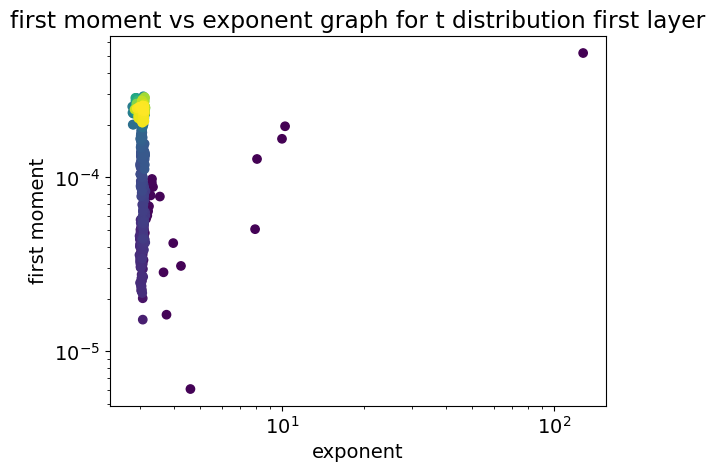

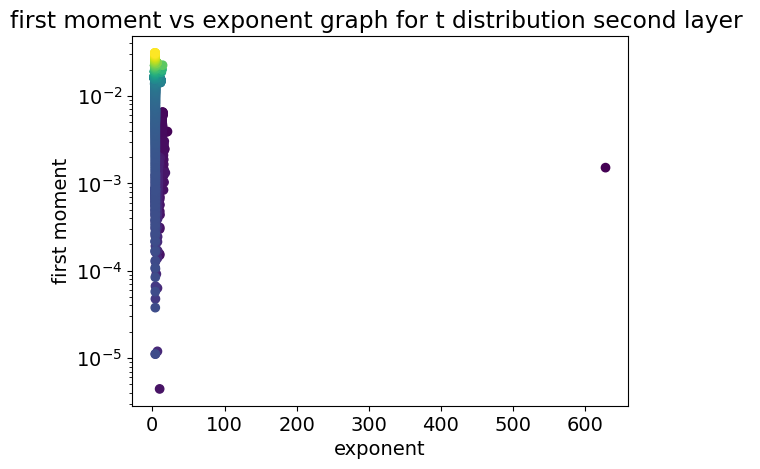

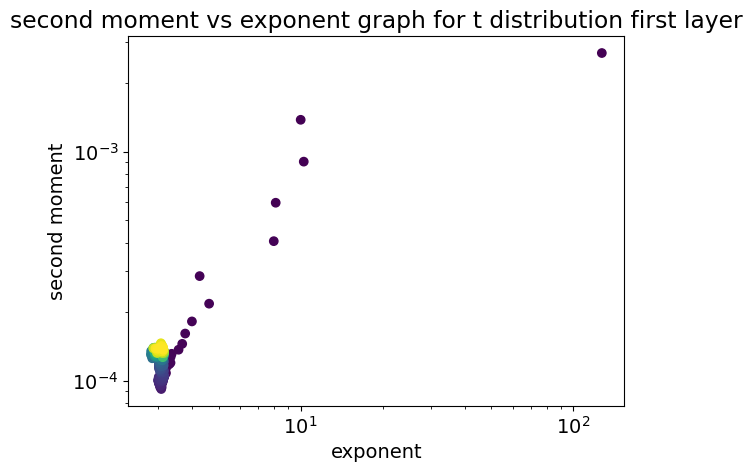

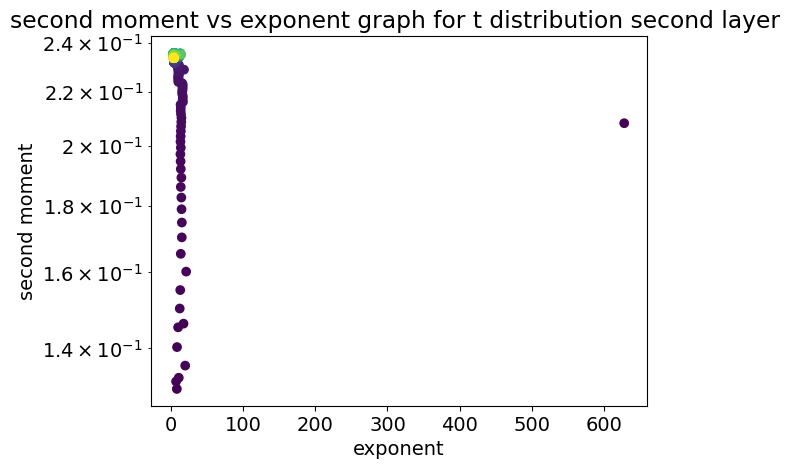

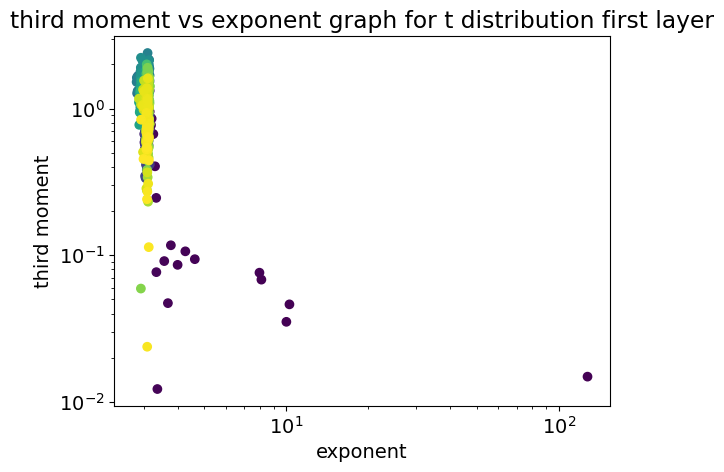

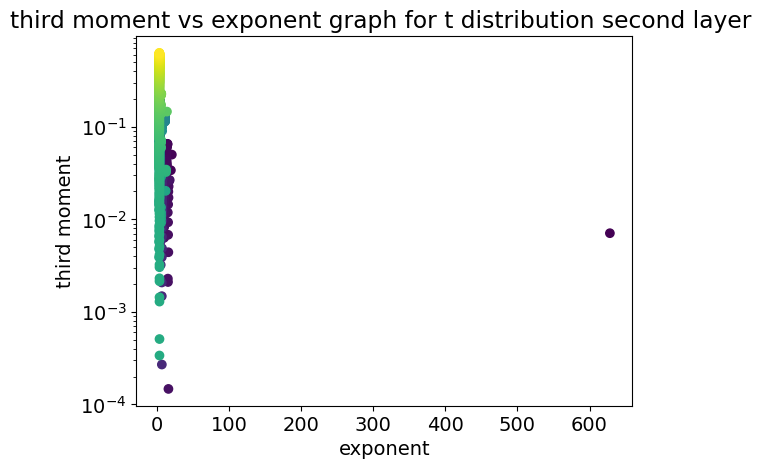

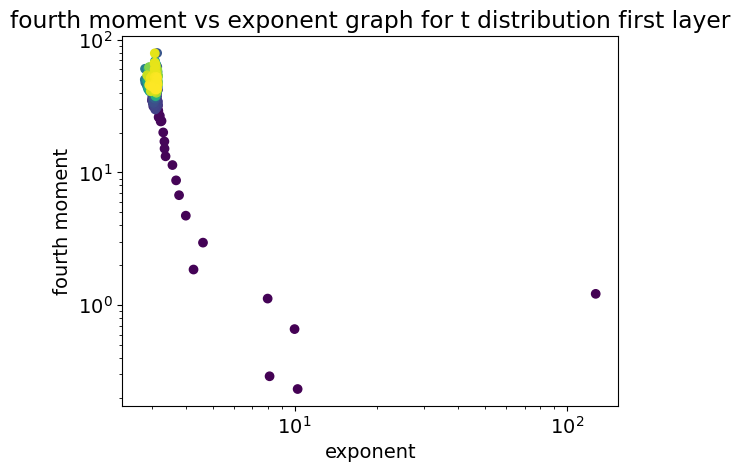

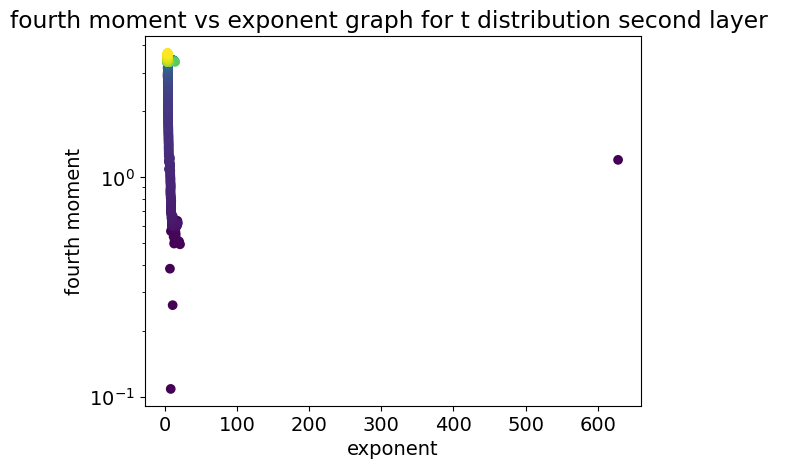

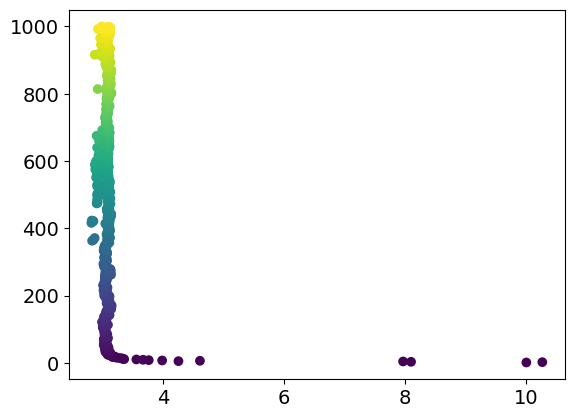

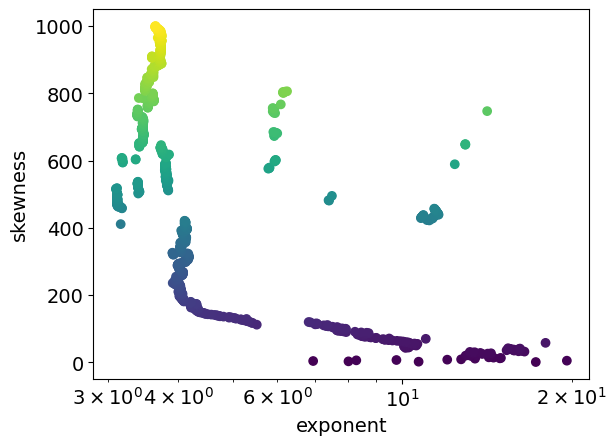

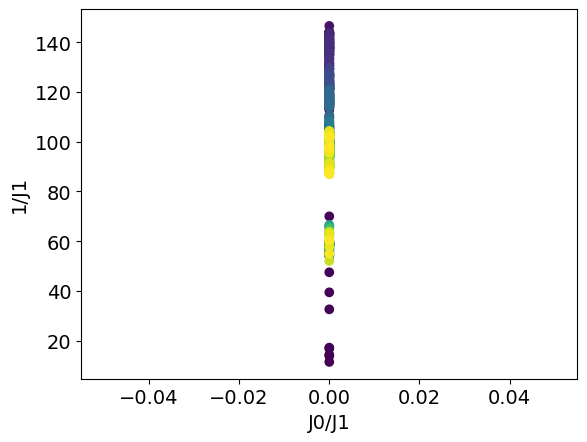

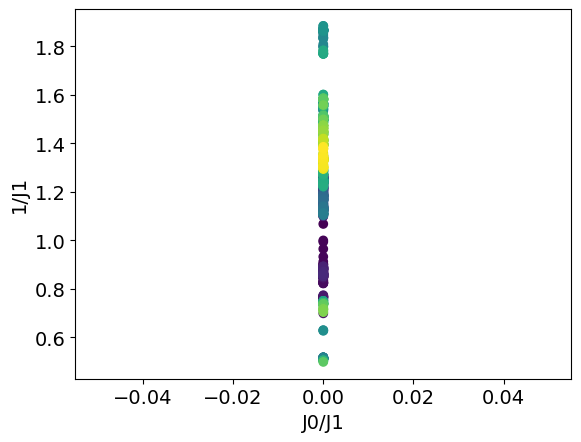

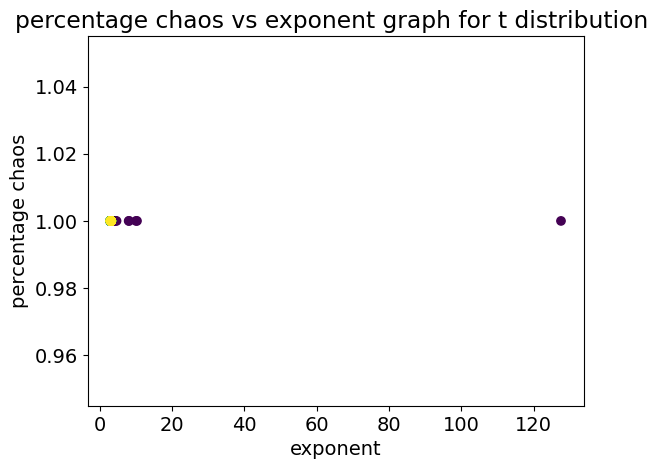

1001
1001
here


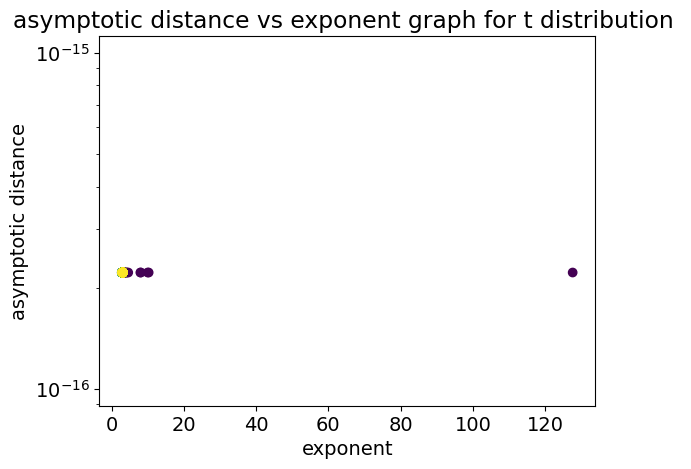

In [29]:
y=np.arange(1001)
color=np.arange(1001)
mu_1=np.asarray(mu)
mu_2=mu_1.reshape(repeats,epochs+1,2)
mu_value=geometric_mean(mu_2)
skewness_1=np.asarray(skewness)
skewness_2=skewness_1.reshape(repeats,epochs+1,2)
skewness_value=geometric_mean(skewness_2)
moment_treatment(mu_value,first_moment,"first")
moment_treatment(mu_value,second_moment,"second")
moment_treatment(mu_value,third_moment,"third")
moment_treatment(mu_value,fourth_moment,"fourth")

first_moment_1=processing(first_moment)
second_moment_1=processing(second_moment)
result=[]
vertical=[]
for i in range(len(J0)):
    #print(first_moment_1[i]/second_moment_1[i])
    result.append(J0[i]/J1[i])
    vertical.append(1/J1[i])
plt.scatter(mu_value.T[0][mu_value.T[0]<20],y[mu_value.T[0]<20],c=color[mu_value.T[0]<20])
plt.show()
plt.scatter(mu_value.T[1][mu_value.T[1]<20],y[mu_value.T[1]<20],c=color[mu_value.T[1]<20])
plt.xlabel("exponent")
plt.ylabel("skewness")
#plt.xlim([0,10])
plt.xscale('log')
plt.savefig(path+file[current_file]+"exponent vs skewness test.jpg")
plt.show()
result_1=np.asarray(result)
result_2=result_1.reshape(repeats,epochs+1,2)
result_value=geometric_mean(result_2)

vertical_1=np.asarray(vertical)
vertical_2=vertical_1.reshape(repeats,epochs+1,2)
vertical_value=geometric_mean(vertical_2)
plt.scatter(result_value.T[0],vertical_value.T[0],c=color)
plt.xlabel("J0/J1")
plt.ylabel("1/J1")
plt.savefig(path+file[current_file]+"phase diagram first layer test.jpg")
plt.show()
plt.scatter(result_value.T[1],vertical_value.T[1],c=color)
plt.xlabel("J0/J1")
plt.ylabel("1/J1")
plt.savefig(path+file[current_file]+"phase diagram second layer test.jpg")
#print(result)
plt.show()
chaos_treatment(mu_value.T[0],average_chaos,"percentage chaos")
print(np.asarray(asymptotic_dist).size)
chaos_treatment(mu_value.T[0],asymptotic_dist,"asymptotic distance")